In [1]:
import gym
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from gym import wrappers
from datetime import datetime
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_approximation import RBFSampler
import HIVTreatment_Gym
%matplotlib inline

In [2]:
def plot_running_avg(totalrewards):
    N = len(totalrewards)
    running_avg = np.empty(N)
    for t in range(N):
        running_avg[t] = totalrewards[max(0, t-100):(t+1)].mean()
    plt.plot(running_avg)
    plt.title("Running Average")
    plt.show()

In [3]:
class SGDRegressor:
    def __init__(self, D):
        self.w = np.random.randn(D) / np.sqrt(D)
        self.lr = 0.1
    def partial_fit(self, X, Y):
        self.w += self.lr*(Y - X.dot(self.w)).dot(X)

    def predict(self, X):
        return X.dot(self.w)

In [4]:
class FeatureTransformer:
    def __init__(self, env):
        # observation_examples = np.array([env.observation_space.sample() for x in range(10000)])
        # NOTE!! state samples are poor, b/c you get velocities --> infinity
        observation_examples = np.random.random((20000, 6))*2 - 1
        scaler = StandardScaler()
        scaler.fit(observation_examples)

        # Used to converte a state to a featurizes represenation.
        # We use RBF kernels with different variances to cover different parts of the space
        featurizer = FeatureUnion([
                ("rbf1", RBFSampler(gamma=0.05, n_components=1000)),
                ("rbf2", RBFSampler(gamma=1.0, n_components=1000)),
                ("rbf3", RBFSampler(gamma=0.5, n_components=1000)),
                ("rbf4", RBFSampler(gamma=0.1, n_components=1000))
                ])
        feature_examples = featurizer.fit_transform(scaler.transform(observation_examples))

        self.dimensions = feature_examples.shape[1]
        self.scaler = scaler
        self.featurizer = featurizer

    def transform(self, observations):
        scaled = self.scaler.transform(observations)
        return self.featurizer.transform(scaled)

In [5]:
# Holds one SGDRegressor for each action
class Model:
    def __init__(self, env, feature_transformer):
        self.env = env
        self.models = []
        self.feature_transformer = feature_transformer
        for i in range(env.action_space.n):
            model = SGDRegressor(feature_transformer.dimensions)
            self.models.append(model)

    def predict(self, s):
        X = self.feature_transformer.transform(np.atleast_2d(s))
        result = np.stack([m.predict(X) for m in self.models]).T
        return result
    
    def update(self, s, a, G):
        X = self.feature_transformer.transform(np.atleast_2d(s))
        self.models[a].partial_fit(X, [G])

    def sample_action(self, s, eps):
        features=self.predict
        if np.random.random() < eps:
              return self.env.action_space.sample()
        else:
              return np.argmax(self.predict(s))

In [6]:
def play_one(env, model, eps, gamma):
    observation = env.reset()
    done = False
    totalreward = 0
    iters = 0
    action = model.sample_action(observation, eps)
    for iters in range(2000):
        obs_features=model.predict(observation)
        next_observation, reward, done, info = env.step(action)

#         if done:
#             reward = -200

    
        next_obs_features = model.predict(next_observation)
        
        next_action=model.sample_action(next_observation,eps)
        
        
        # print(next.shape)
        assert(next_obs_features.shape == (1, env.action_space.n))
        assert(obs_features.shape)==(1,env.action_space.n)
        #import pdb;pdb.set_trace()
        G = reward + gamma*(eps*np.mean(next_obs_features)+(1-eps)*np.max(next_obs_features))
       
        model.update(observation, action, G)
        totalreward += reward
#         if reward == 1: # if we changed the reward to -200
#             totalreward += reward
        iters += 1
        observation=next_observation
        action=next_action
        if done:
            break

    return totalreward

In [7]:
def main():
    env = gym.make('HIV-v0')
    ft = FeatureTransformer(env)
    model = Model(env, ft)
    gamma = 0.99

    if 'monitor' in sys.argv:
        filename = os.path.basename(__file__).split('.')[0]
        monitor_dir = './' + filename + '_' + str(datetime.now())
        env = wrappers.Monitor(env, monitor_dir)


    N = 10000
    totalrewards = np.empty(N)
    costs = np.empty(N)
    for n in range(N):
        
        eps = 1.0/np.sqrt(n+1)
        totalreward = play_one(env, model, eps, gamma)
        totalrewards[n] = totalreward
        if n % 1000 == 0:
            print("episode:", n, "total reward:", totalreward, "eps:", eps, "avg reward (last 1000):", totalrewards[max(0, n-1000):(n+1)].mean())
    
            
        
    print("avg reward for last 1000 episodes:", totalrewards[-1000:].mean())
    print("total steps:", totalrewards.sum())
    
    return totalrewards,env

Run  1
episode: 0 total reward: 8269699.0058665145 eps: 1.0 avg reward (last 1000): 8269699.0058665145
episode: 1000 total reward: 28802727888.12142 eps: 0.0316069770620507 avg reward (last 1000): 16664210648.660387
episode: 2000 total reward: 31612520223.996532 eps: 0.022355091700494795 avg reward (last 1000): 31211523415.119568
episode: 3000 total reward: 37058859688.3553 eps: 0.01825437644092281 avg reward (last 1000): 33941189972.61968
episode: 4000 total reward: 39317410409.61793 eps: 0.015809412247806517 avg reward (last 1000): 35487397400.04577
episode: 5000 total reward: 43108147333.033066 eps: 0.014140721622265264 avg reward (last 1000): 36810912646.486206
episode: 6000 total reward: 36065825100.875404 eps: 0.012908868793110689 avg reward (last 1000): 37149995094.482925
episode: 7000 total reward: 39454010472.7313 eps: 0.011951432450083671 avg reward (last 1000): 37426688983.966736
episode: 8000 total reward: 20930505018.60961 eps: 0.01117964118175896 avg reward (last 1000): 3

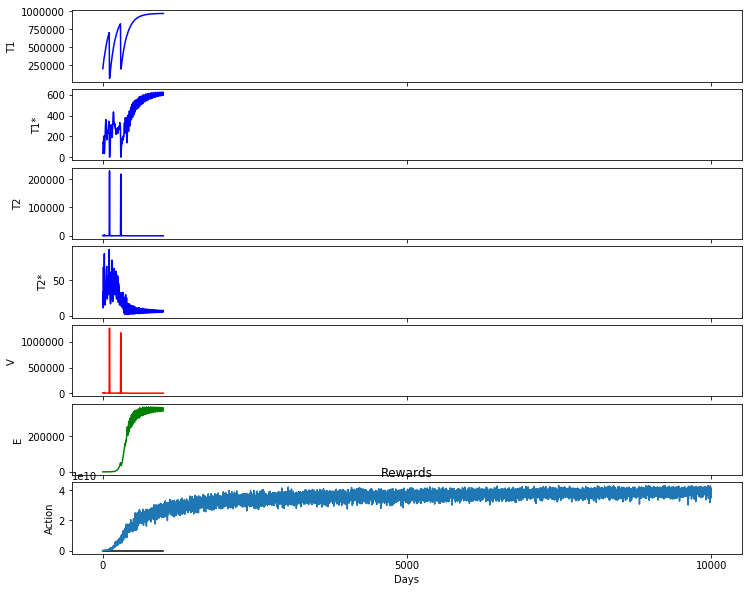

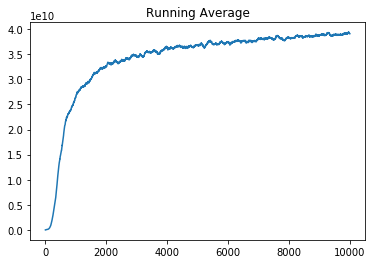

In [8]:
##Taking the average
num_experiments=5
all_rewards=[]
for i in range(num_experiments):
    print("Run ",i+1)
    
    totalrewards,env=main()
    all_rewards.append(totalrewards)
average_rewards=np.mean(all_rewards,axis=0)
env.showDomain()
plt.plot(average_rewards)
plt.title("Rewards")
np.save('All_rewards_expected_sarsa.npy',all_rewards)
plt.show()

plot_running_avg(average_rewards)



## Approach :
  The previous implementations of KBRL are unable to converge thus we now move to a different choice of kernel and method of implementation. We decide to use the Radial Basis Function (RBF) kernel.
  
  The RBF kernel model can be thought of as a linear  model with feature extraction where the feature extractor is a RBF kernel.
  
  Mathematically the RBF kernel can be expressed as:
  $$\phi (x)=exp(-\frac{||x-c||^{2}}{\sigma^{2}})$$
  
  where:
         $x$= input vector
         $c$ = center or exemplar vector
         $\sigma$ = scale parameter.
         
  Note that $c$ is a hyper-parameter and needs to be found by experimentation.
  
  We use the RBF-sampler from scikit-learn and sample from the state space to train a linear regresor to learns its feature.
  Since we are not sure which scale parameter $\sigma$ is good we use multiple RBF kernels with different scale parameters. We also use one step of a gradient descent to integrate it with the Q learning mechanism.
  
Another implementation detail worth noting is that we only extract the features from the state $s$ and learn a different linear-model for each action.